In [1]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
from sqlalchemy import text

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/bj/rccpnj4157jddx7v18bv2c200000gn/T/ipykernel_1653/2835508603.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table (make object)
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB (Create session to the engine)
session = Session(engine)

In [10]:
# inspect data from tables
inspector = inspect(engine)

for key in Base.classes.keys():
    columns = inspector.get_columns(key)

    s = "-"
    print(f"{s * 10} {key} {s * 10}")

    for column in columns:
        print(column["name"], column["type"])

---------- station ----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
---------- measurement ----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
dir(engine)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compiled_cache',
 '_connection_cls',
 '_echo',
 '_execution_options',
 '_has_events',
 '_is_future',
 '_is_protocol',
 '_lru_size_alert',
 '_option_cls',
 '_optional_conn_ctx_manager',
 '_run_ddl_visitor',
 '_schema_translate_map',
 '_should_log_debug',
 '_should_log_info',
 '_sqla_logger_namespace',
 'begin',
 'clear_compiled_cache',
 'connect',
 'dialect',
 'dispatch',
 'dispose',
 'driver',
 'echo',
 'engine',
 'execution_options',
 'get_execution_options',
 'hide_parameters',
 'logger',
 'logging_name',
 'n

In [20]:
# Visualize table MEASUREMENT
statement = "SELECT * FROM measurement ORDER BY id DESC LIMIT 5"
with engine.connect() as conn:
    result = conn.execute(text(statement)).fetchall()

result

[(19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (19548, 'USC00516128', '2017-08-21', 0.56, 76.0),
 (19547, 'USC00516128', '2017-08-20', None, 78.0),
 (19546, 'USC00516128', '2017-08-19', 0.09, 71.0)]

In [21]:
# Visualize table STATION
statement = "SELECT * FROM station ORDER BY id"
with engine.connect() as conn:
    result = conn.execute(text(statement)).fetchall()

result

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

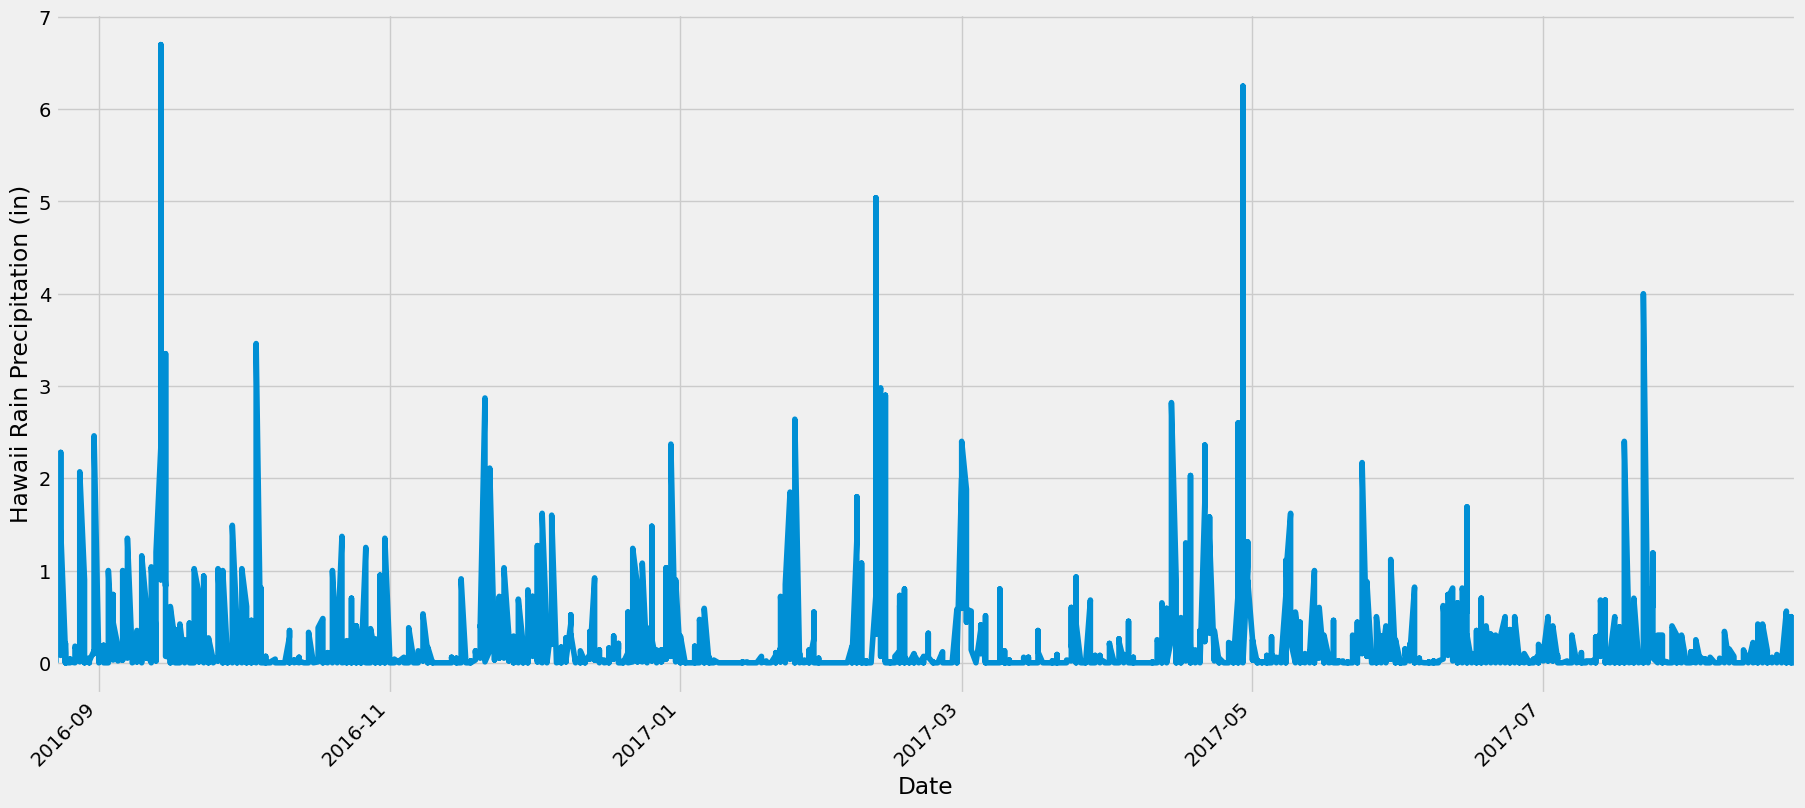

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastDate = list(session.query(Measurement.date).all())[-1][0]
startingDate = (pd.to_datetime(lastDate) - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
twelveMonthData = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= startingDate)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(twelveMonthData, columns=["Date", "Precipitation (in)"])

precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])

precipitation_df = precipitation_df.dropna().set_index(["Date"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(20, 10), rot=45, legend=False)

plt.xlabel("Date")
plt.ylabel("Hawaii Rain Precipitation (in)")

plt.xlim([min(precipitation_df.index), max(precipitation_df.index)])

plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,Precipitation (in)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(func.count(Station.station)).all()

print(f"There are a total of {stationCount[0][0]} stations in this database")

There are a total of 9 stations in this database


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
stationsActivity = session.query(
    Measurement.station, func.count(Measurement.station)
).group_by(Measurement.station)

# List the stations and the counts in descending order.
stationsActivity = stationsActivity.order_by(
    func.count(Measurement.station).desc()
).all()

stationsActivity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded and average temperature of the most active station?

mostActiveStation = stationsActivity[0][0]

stations_dict = {}

for i in stationsActivity:
    station = i[0]

    lowestTemp = (
        session.query(func.min(Measurement.tobs))
        .filter(Measurement.station == station)
        .all()
    )
    maxTemp = (
        session.query(func.max(Measurement.tobs))
        .filter(Measurement.station == station)
        .all()
    )
    averageTemp = (
        session.query(func.avg(Measurement.tobs))
        .filter(Measurement.station == station)
        .all()
    )

    stations_dict[station] = {
        "Min. Temperature (F)": lowestTemp[0][0],
        "Max. Temperature (F)": maxTemp[0][0],
        "Avg. Temperature (F)": round(averageTemp[0][0], 2),
    }

stations_dict

print(
    f"{mostActiveStation} was the most active station from {session.query(Measurement.date).first()[0]} to {session.query(func.max(Measurement.date)).first()[0]}\
\nThe lowest temperature recorded in this station was {stations_dict[mostActiveStation]['Min. Temperature (F)']} °F.\
\nThe highest temperature recorded in this station was  {stations_dict[mostActiveStation]['Max. Temperature (F)']} °F.\
\nThe average  temperature recorded in this station was {stations_dict[mostActiveStation]['Avg. Temperature (F)']} °F"
)

USC00519281 was the most active station from 2010-01-01 to 2017-08-23
The lowest temperature recorded in this station was 54.0 °F.
The highest temperature recorded in this station was  85.0 °F.
The average  temperature recorded in this station was 71.66 °F


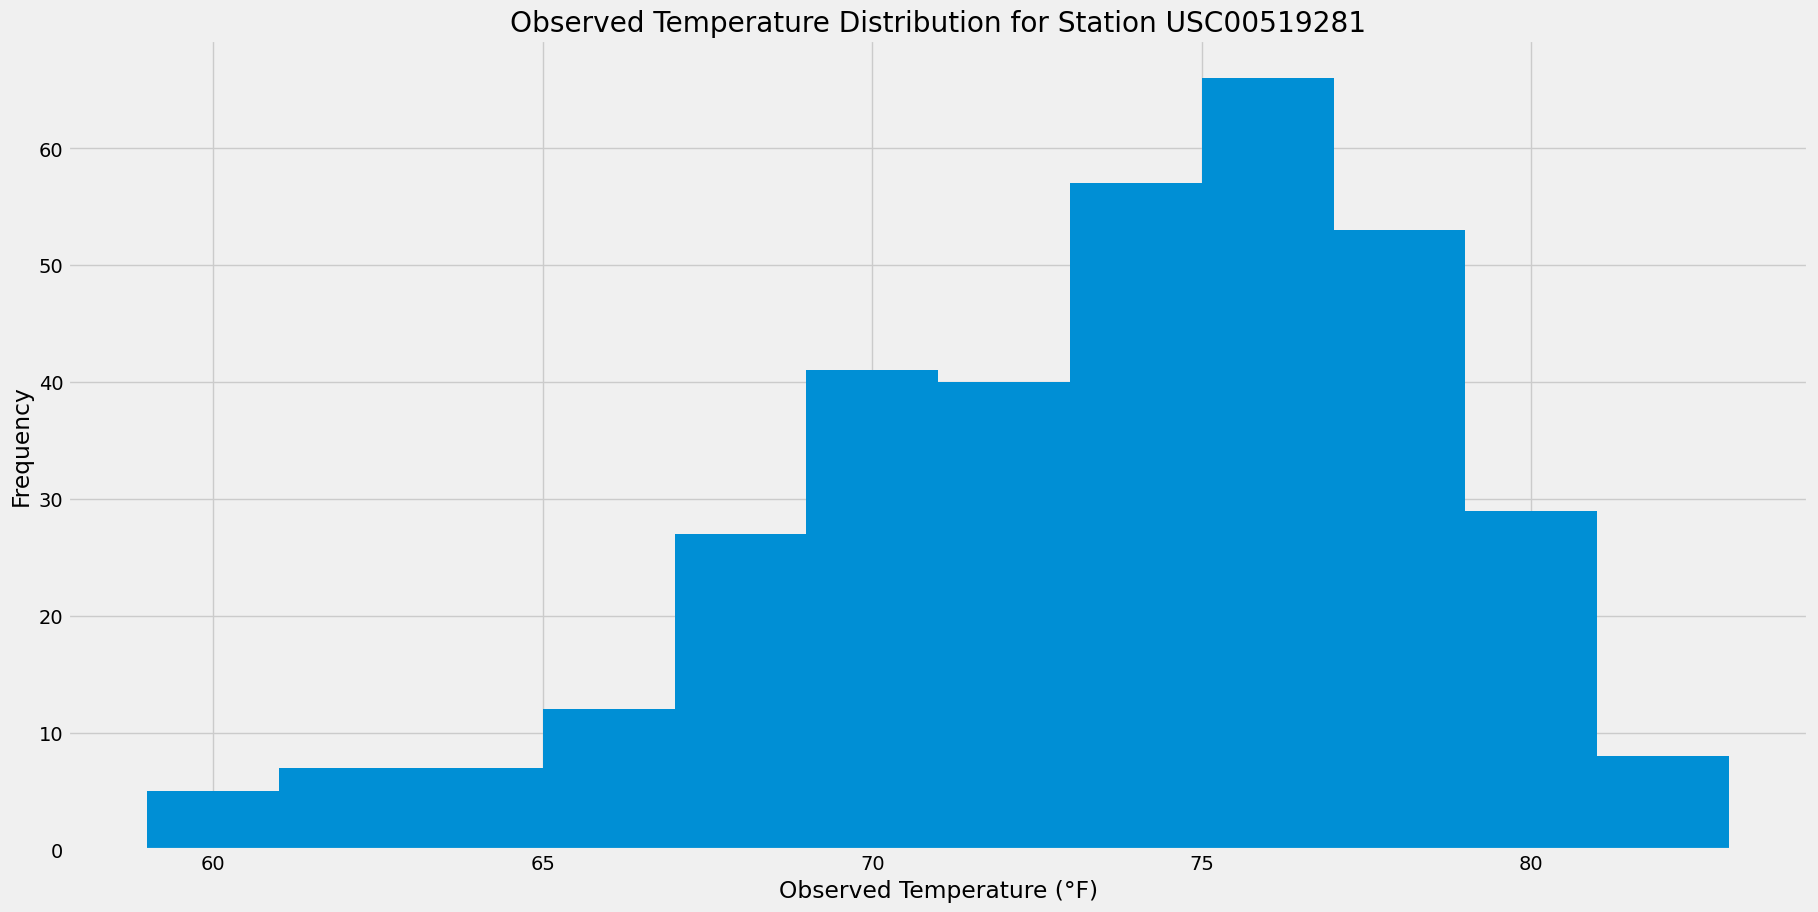

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

twelveMonthDataTempStation = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date >= startingDate)
    .filter(Measurement.station == mostActiveStation)
    .order_by(Measurement.date)
    .all()
)


mostActiveStationTemp_df = (
    pd.DataFrame(
        twelveMonthDataTempStation, columns=["Date", "Observed Temperature (°F)"]
    )
    .fillna(0)
    .set_index(["Date"])
)

# Sort the dataframe by date
mostActiveStationTemp_df = mostActiveStationTemp_df.sort_values("Date")


mostActiveStationTemp_df.plot.hist(figsize=(20, 10), legend=False, bins=12)
plt.xlabel("Observed Temperature (°F)")
plt.title(f"Observed Temperature Distribution for Station {mostActiveStation}")
plt.show()

## Bonus Challenge Assignment

In [28]:
startVacationDate = dt.date(2017, 6, 10)
endVacation = startVacationDate + dt.timedelta(days=15)


# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d

    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.

lastYearStart = startVacationDate - dt.timedelta(days=365)
lastYearEnd = endVacation - dt.timedelta(days=365)

print(calc_temps(lastYearStart, lastYearEnd))

[(69.0, 75.98076923076923, 81.0)]


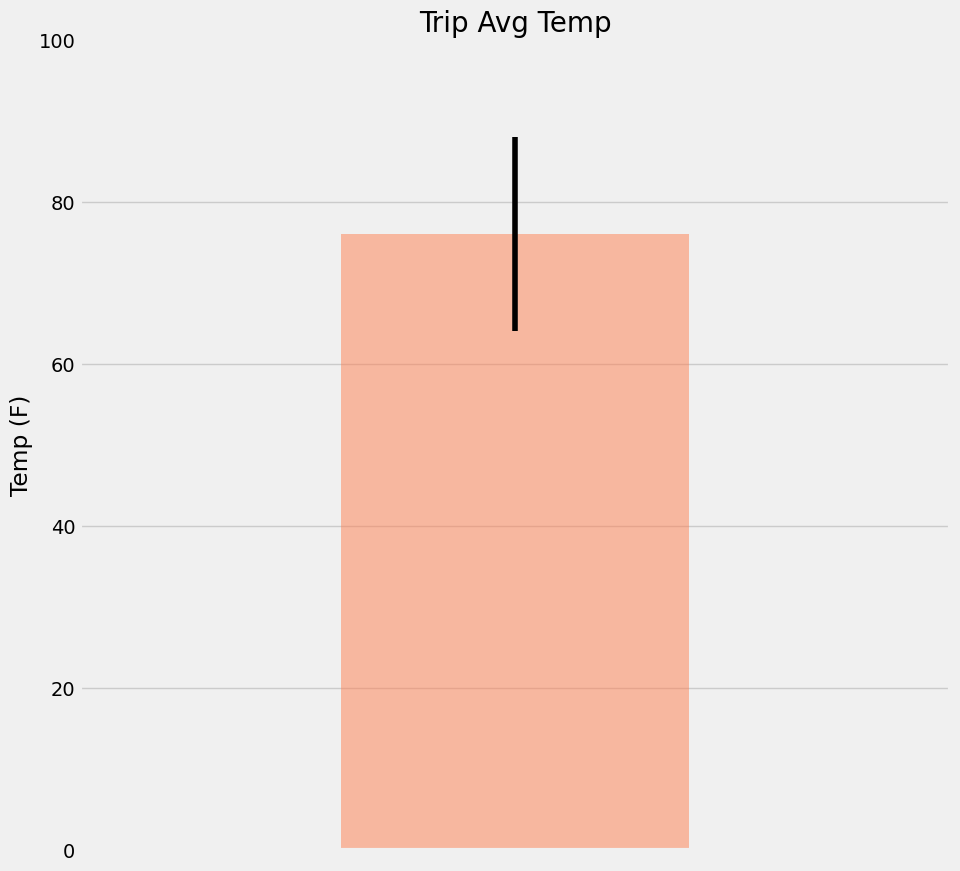

In [30]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

averageTempLastyear = calc_temps(lastYearStart, lastYearEnd)[0][1]

minMaxLastYear = (
    calc_temps(lastYearStart, lastYearEnd)[0][2]
    - calc_temps(lastYearStart, lastYearEnd)[0][0]
)

plt.figure(figsize=(10, 10))

plt.bar(
    0, averageTempLastyear, width=0.8, yerr=minMaxLastYear, color="coral", alpha=0.5
)

plt.ylim(0, 100)
plt.xlim(-1, 1)

plt.xticks([])

plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp", fontsize=20)

plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tripData = (
    session.query(Measurement.station, func.sum(Measurement.prcp))
    .filter(Measurement.date >= lastYearStart)
    .filter(Measurement.date <= lastYearEnd)
    .order_by(func.sum(Measurement.prcp).desc())
    .group_by(Measurement.station)
    .all()
)

tripData_df = pd.DataFrame(tripData, columns=["Station", "Total Precipitation (in)"])

stationData = session.query(
    Station.station,
    Station.name,
    Station.latitude,
    Station.longitude,
    Station.elevation,
).all()

station_df = pd.DataFrame(
    stationData, columns=["Station", "Name", "Latitude", "Longitude", "Elevation"]
)

merguedStationTrip_df = pd.merge(tripData_df, station_df, on="Station", how="inner")

merguedStationTrip_df

,Station,Total Precipitation (in),Name,Latitude,Longitude,Elevation
0,USC00516128,9.55,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,4.55,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,2.22,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,2.00,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,1.03,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00517948,0.60,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,USC00519397,0.17,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [32]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.

    Args:
        date (str): A date string in the format '%m-%d'

    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax

    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
dateRange = pd.date_range(start=str(startVacationDate), end=str(endVacation)).tolist()
# Stip off the year and save a list of %m-%d strings
dateRangeFormatted = [i.strftime("%m-%d") for i in dateRange]

# Loop through the list of %m-%d strings and calculate the normals for each date
normalsList = []

for i in dateRangeFormatted:
    normalsList.append(daily_normals(i))

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
plotDateRangeFormatted = [i.strftime("%Y-%m-%d") for i in dateRange]
normal_dict = {
    "Min. Temperature (°F)": [],
    "Avg. Temperature (°F)": [],
    "Max. Temperature (°F)": [],
}

for i in normalsList:
    normal_dict["Min. Temperature (°F)"].append(i[0][0])
    normal_dict["Avg. Temperature (°F)"].append(i[0][1])
    normal_dict["Max. Temperature (°F)"].append(i[0][2])

dailyNormals_df = pd.DataFrame(normal_dict, index=plotDateRangeFormatted)

dailyNormals_df.head()

,Min. Temperature (°F),Avg. Temperature (°F),Max. Temperature (°F)
2017-06-10,68.0,75.142857,81.0
2017-06-11,69.0,76.019608,84.0
2017-06-12,66.0,75.666667,83.0
2017-06-13,68.0,75.666667,81.0
2017-06-14,69.0,75.627119,81.0


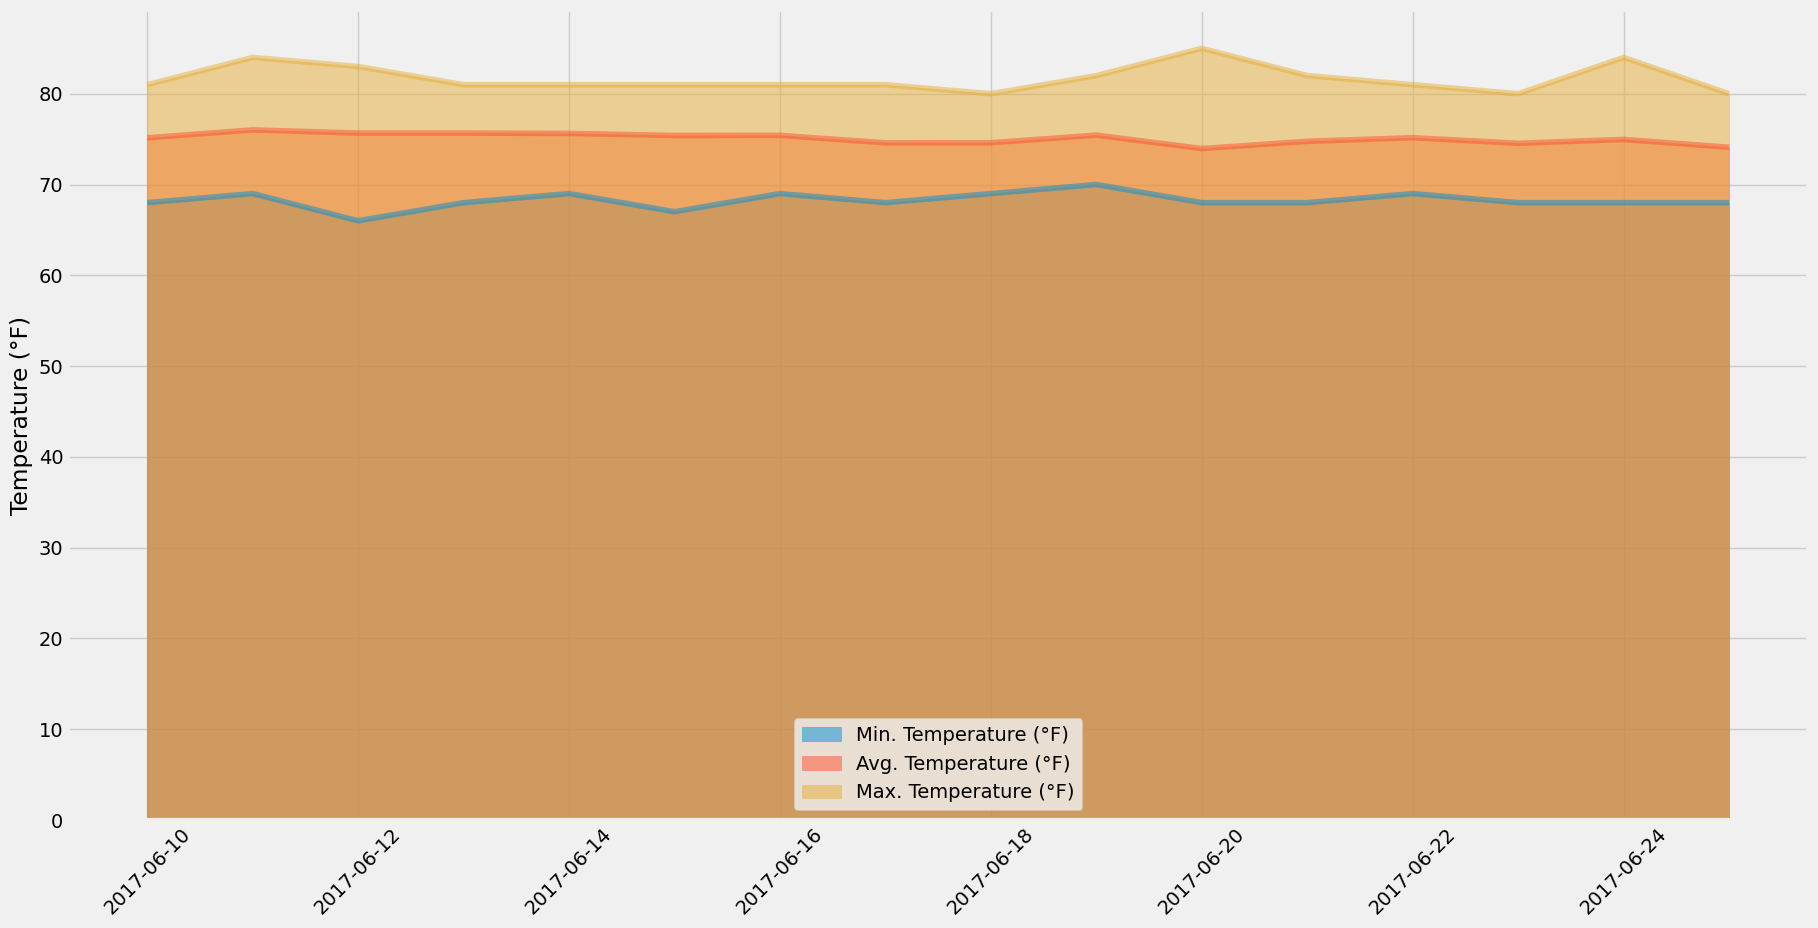

In [35]:
# Plot the daily normals as an area plot with `stacked=False`

dailyNormals_df.plot.area(stacked=False, figsize=(20, 10), rot=45)
plt.ylabel("Temperature (°F)")
plt.show()

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why? 

> I used an unpaired t-test (independent) because this test compares the means and variances of two unrelated groups to determine if there is a significant difference between the two. Even tough, geographically speaking the samples were taken in the same area; weather patterns are affected by so many different factors that it can be considered independent.
After performing a T-Test for June and December I obtained a T-value of 31 with a p-value of 0 indicating that with at least 95% certainty that we have a statistically significant difference.





In [36]:
import random

from scipy import stats

JuneData = (
    session.query(Measurement.tobs)
    .filter(func.strftime("%m", Measurement.date) == "06")
    .all()
)

JuneVariance = np.var(JuneData)
JuneMean = np.mean(JuneData)
JuneSTD = np.std(JuneData)
print(
    f"June: mean {JuneMean:.2f}, standard dev {JuneSTD:.2f}, variance {JuneVariance:.2f}"
)

DecData = (
    session.query(Measurement.tobs)
    .filter(func.strftime("%m", Measurement.date) == "12")
    .all()
)

DecVariance = np.var(DecData)
DecMean = np.mean(DecData)
DecSTD = np.std(DecData)
print(
    f"December: mean {DecMean:.2f}, standard dev {DecSTD:.2f}, variance {DecVariance:.2f} \n"
)

# independent ttest.--------
# Sample size do not have to be the same.

# Independent two sample T-Test
independentTTest = stats.ttest_ind(
    JuneData, DecData, equal_var=False
)  # They do not have the same variance equal_var = false


print(
    f"T-Test results: t-value is {independentTTest[0][0]:.2f} and the p-value is {independentTTest[1][0]:.2f}"
)


# if p value is less than 0.05 we are 95% sure that there is a something is happening (Statistaclly significant)

June: mean 74.94, standard dev 3.26, variance 10.60
December: mean 71.04, standard dev 3.74, variance 14.02 

T-Test results: t-value is 31.36 and the p-value is 0.00


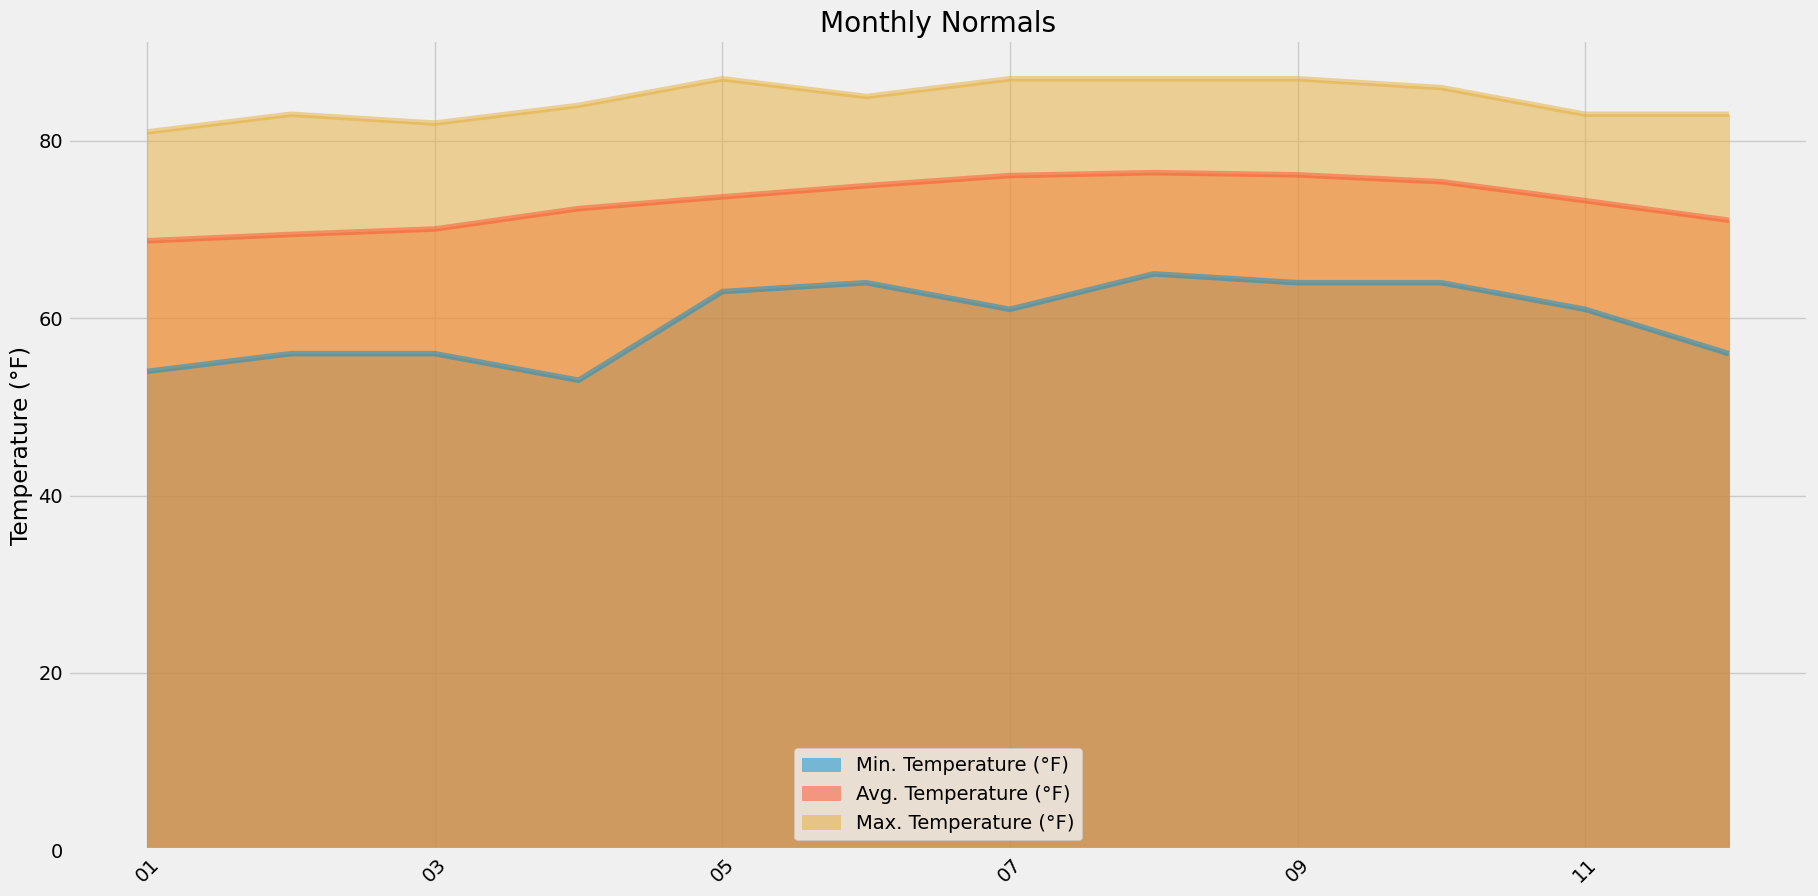

In [37]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]


def monthly_normals(date):
    """Daily Normals.

    Args:
        date (str): A date string in the format '%m-%d'

    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax

    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel).filter(func.strftime("%m", Measurement.date) == date).all()
    )


MonhtlynormalsList = []

for i in months:
    MonhtlynormalsList.append(monthly_normals(i))

normalM_dict = {
    "Min. Temperature (°F)": [],
    "Avg. Temperature (°F)": [],
    "Max. Temperature (°F)": [],
}

for i in MonhtlynormalsList:
    normalM_dict["Min. Temperature (°F)"].append(i[0][0])
    normalM_dict["Avg. Temperature (°F)"].append(i[0][1])
    normalM_dict["Max. Temperature (°F)"].append(i[0][2])

monhtlyNormals_df = pd.DataFrame(normalM_dict, index=months)

monhtlyNormals_df.plot.area(stacked=False, figsize=(20, 10), rot=45)
plt.title("Monthly Normals")
plt.ylabel("Temperature (°F)")
plt.show()

In [38]:
# Dependent ttest --------------------

# #For this test the samples need to have the size.
# #June has more data than december.
# listToSample = JuneData

# #Calculates the extra samples and the number number of samples we would like to keep in the list.
# number_extra = len(JuneData) - len(DecData)
# number_to_keep = len(JuneData) - number_extra

# #Picks a randome sample of numbers from the original list based on the total of number of samples we want to keep.
# sampledJuneData = random.sample(listToSample, number_to_keep)

# dependentTtest = stats.ttest_rel(sampledJuneData,DecData)

# print(f'The t-value for the dependet sample is {dependentTtest[0][0]:.2f} and the p-value is {dependentTtest[1][0]:.2f}')
